In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from IPython.display import Audio

import scipy.integrate as integrate

%matplotlib inline

In [2]:
#source: https://dspillustrations.com/pages/posts/misc/spectral-leakage-zero-padding-and-frequency-resolution.html

# Spectral Leakage and Zero-Padding of the Discrete Fourier Transform

The discrete Fourier Transform is of extreme importance for all kinds of digital signal processing tasks. Given an input sequence $x[n]$ of length $N$ samples, the DFT is given by $$X[k] = \sum_{n=0}^{N-1}x[n]\exp(-j2\pi\frac{nk}{N}).$$
It is used for filtering, spectral analysis, complexity reduction, equalization and so many other kinds of analysis. In this article, we are going to illustrate the properties of the discrete Fourier Transform which are different from the conventional, time-continuous Fourier transform. We will describe the effect of zero-padding versus using a larger FFT window for spectral analysis. Finally, we will apply this knowledge to the detection of [dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling "Wikipedia entry"), how it is used in the standard [phone dialing](https://en.wikipedia.org/wiki/Telephone_keypad "Wikipedia entry").

Let us first pose the central property of the DFT:
> The Discrete Fourier Transform (DFT) assumes that its input signal is one period of a periodic signal. Its output are the discrete frequencies of this periodic signal.

## Fourier Transform of periodic and windowed functions
This central property is very important to understand. Let us first examine the (continuous-time) Fourier transform of some periodic signal. To do this, we define a function that calculates the continuous-time Fourier Transform (see also [this post](http://dspillustrations.com/pages/posts/misc/approximating-the-fourier-transform-with-dft.html))

In [3]:
def cft(g, f):
    """Numerically evaluate the Fourier Transform of g for the given frequencies"""    
    result = np.zeros(len(f), dtype=complex)
    
    # Loop over all frequencies and calculate integral value
    for i, ff in enumerate(f):
        # Evaluate the Fourier Integral for a single frequency ff, 
        # assuming the function is time-limited to abs(t)<5
        result[i] = complex_quad(lambda t: g(t)*np.exp(-2j*np.pi*ff*t), -10, 10)
    return result

def complex_quad(g, a, b):
    """Return definite integral of complex-valued g from a to b, 
    using Simpson's rule"""
    # 2501: Amount of used samples for the trapezoidal rule
    t = np.linspace(a, b, 2501)  
    x = g(t)
    return integrate.simps(y=x, x=t)

Let us plot the Fourier Transform of a triangular function, just to check if our function is correct.

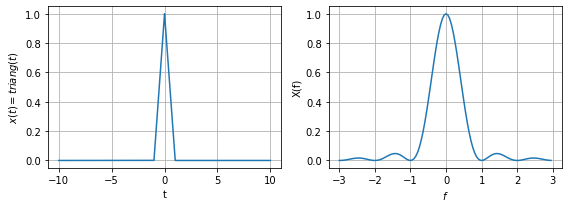

In [4]:
def triang(t):
    return (1-abs(t)) * (abs(t)<1).astype(float)
Fs = 10000
t = np.arange(-10, 10, 1/Fs)

f = np.arange(-3, 3, 1/20.)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, triang(t))
plt.grid(True)
plt.xlabel('t')
plt.ylabel(r'$x(t)=triang(t)$')
plt.subplot(122)
cft_triang = cft(triang, f)
plt.plot(f, abs(cft_triang));
plt.xlabel('$f$'); plt.ylabel('X(f)');
plt.grid(True)
plt.tight_layout();

Apparently, the Fourier Transform of a triangle is a sinc-Function squared (its actual shape is not important here). Now, let's consider the Fourier Transform of a periodic signal, and plot the Fourier Transform of the non-periodic signal on top of it:

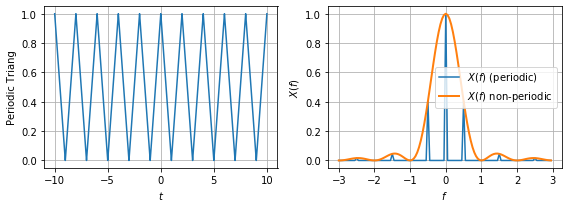

In [5]:
def periodic_triang(t):
    return triang(np.mod(t+1, 2)-1)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, periodic_triang(t));
plt.grid()
plt.xlabel('$t$'); plt.ylabel('Periodic Triang')

plt.subplot(122)
# Energy correction /10, since the periodic signal has 10 periods (i.e. 10 times the power)
cft_periodic_triang = cft(periodic_triang, f) / 10
plt.plot(f, abs(cft_periodic_triang), '-', label='$X(f)$ (periodic)')
plt.plot(f, abs(cft_triang), label='$X(f)$ non-periodic', lw=2); 
plt.grid(True); plt.legend(fontsize=10)
plt.xlabel('$f$'); plt.ylabel('$X(f)$');
plt.tight_layout();

As is shown, suddenly the spectrum of the periodic signal becomes discrete, but follows the shape of the continuous spectrum. I.e. **he spectrum of the periodic signal is a sampled version of the continuous spectrum**. The input signal has a period $T=2$, i.e. the signal is repeated every $T=2$ seconds. Accordingly, its spectrum is non-zero every $1/T=0.5Hz$. 

Now, let us consider the spectrum of an originally periodic function, but which was windowed by a rectangular function:

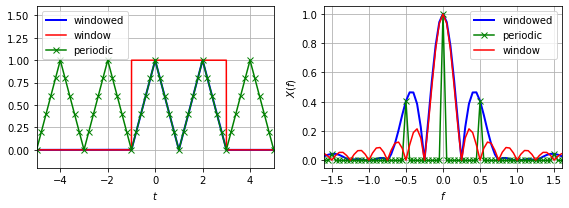

In [6]:
def rect(t):
    return (abs(t)<0.5).astype(float)
window = lambda t: rect((t-1)/4)
def windowed_periodic_triang(t):
    return periodic_triang(t) * window(t)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, windowed_periodic_triang(t), 'b-', label='windowed', lw=2);
plt.plot(t, window(t), 'r-', label='window')
plt.plot(t, periodic_triang(t), 'g-x', label='periodic', markevery=2000)
plt.xlabel('$t$');
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.ylim((-0.2, 1.6));
plt.xlim((-5, 5))

cft_windowed_periodic_triang = cft(windowed_periodic_triang, f) / 2
cft_window = cft(window, f) / 4
plt.subplot(122)
plt.plot(f, abs(cft_windowed_periodic_triang), 'b-', label='windowed', lw=2);
plt.plot(f, abs(cft_periodic_triang), 'g-x', label='periodic')
plt.plot(f, abs(cft_window), 'r-', label='window')
plt.xlabel('$f$'); plt.ylabel('$X(f)$');
plt.legend(fontsize=10)
plt.grid(); plt.tight_layout();
plt.xlim((-1.6, 1.6));

Suddenly, the spectrum becomes continuous again (that's clear, as the signal is not periodic anymore), but it crosses the value at the discrete points from the periodic signal (green line). Mathematically, this is explained by the fact that multiplication in time-domain (i.e. windowing by the rect function of width $T=4$) relates to convolution in frequency domain (i.e. convolution with a sinc-function that has zeros every $F=1/T=0.25$Hz, see red curve).

Now, let us make an extreme, and window our periodic function to only one period:

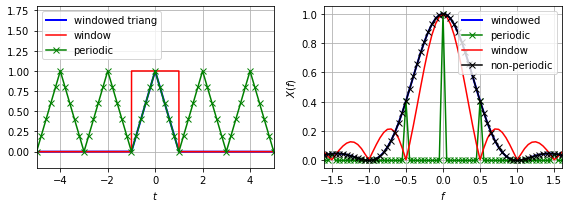

In [7]:
window = lambda t: rect(t/2)
def windowed_periodic_triang(t):
    return periodic_triang(t) * window(t)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, windowed_periodic_triang(t), 'b-', label='windowed triang', lw=2);
plt.plot(t, window(t), 'r-', label='window')
plt.plot(t, periodic_triang(t), 'g-x', label='periodic', markevery=2000)
plt.xlabel('$t$');
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.ylim((-0.2, 1.8));
plt.xlim((-5, 5))

cft_windowed_periodic_triang = cft(windowed_periodic_triang, f)
cft_window = cft(window, f) / 2
plt.subplot(122)
plt.plot(f, abs(cft_windowed_periodic_triang), 'b-', label='windowed', lw=2);
plt.plot(f, abs(cft_periodic_triang), 'g-x', label='periodic')
plt.plot(f, abs(cft_window), 'r-', label='window')
plt.plot(f, abs(cft_triang), 'k-x', label='non-periodic')
plt.xlabel('$f$'); plt.ylabel('$X(f)$');
plt.legend(fontsize=10)
plt.grid(); plt.tight_layout();
plt.xlim((-1.6, 1.6));

Naturally, when windowing the periodic function to just one period, it becomes the original (non-periodic) function. Hence, the spectrum of the windowed periodic (blue curve) and non-periodic function (black crosses) are equal. The blue spectrum is the convolution of the red curve (window) with the green curve (periodic function).

Let us summarize our findings on the continuous-time Fourier Transform:

> - The Fourier Transform of a non-periodic function is a continuous function.
> - The Fourier Transform of a periodic function with period $T$ is a discrete spectrum, where the spectral lines are $1/T$ apart.
> - The Fourier Transform of a periodic function with period $T$, that was windowed with a (rectangular) window of length $T_W$ is again a continuous function. Its value equals the convolution of the discrete spectrum of the continuous function with the spectrum of the window.

## The Discrete Fourier Transform
Now, that we have found properties of the continuous-time Fourier Transform regarding periodicity and windowing, let us recall the fundamental thing for the DFT:

> The Discrete Fourier Transform (DFT) assumes that its input signal is one period of a periodic signal. Its outputs are the discrete frequencies of this periodic signal.

What does that mean? 

1) If we calculate the DFT of some sequence, the DFT assumes the signal is actually a periodic repetition of this sequence:

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app


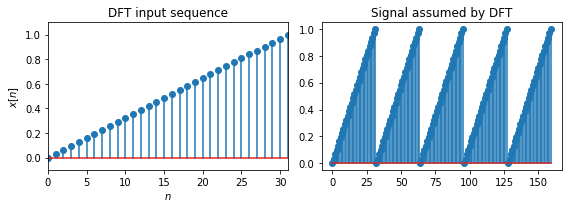

In [8]:
n = np.arange(32)
xn = np.linspace(0, 1, len(n))

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.stem(n, xn);
plt.xlabel('$n$')
plt.ylabel('$x[n]$');
plt.xlim(0, len(n)-1)
plt.ylim((-0.1, 1.1))
plt.title('DFT input sequence');

xn_periodic = np.hstack([xn]*5)
plt.subplot(122)
plt.stem(xn_periodic)
plt.title('Signal assumed by DFT')
plt.tight_layout();

2) As we know from before, the spectrum of a periodic function with period $T$ is discrete, where the spectral lines occur in distance $1/T$. Let us now consider, our DFT input sequence consists of $N$ samples (e.g. $N=$128), that are sampled with frequency $F_s$ (e.g. $F_s=$1kHz), i.e. the samples are $T_s=1/F_s$ apart in time (e.g. $T_s=$1ms). Then, the overall length of the input sequence is $T=N/F_s$ (e.g. $T=$128ms). Hence, the DFT calculates the spectrum at the spectral lines, which are $\Delta_f=1/T$ apart (e.g. $\Delta_f=7.8125$Hz). This leads to the fist important measure for the DFT:

> The distance between frequency bins $\Delta_f$ of the DFT output only depends on the length of the input sequence $T$ and is given by $$\Delta_f=1/T_s.$$ The distance between frequency bins does not depend on the sampling frequency.

The output of the DFT consists of $N$ frequency bins, which are $\Delta_f$ apart. Hence, the maximum frequency that is representable by the DFT is given by $F_{\max}=N\Delta_f=N/T=N/(N/F_s)=F_s$, which leads us to the second important property of the frequency bins.

> The frequency range that is represented by the output of the DFT is given by $$F_{\max}=F_s.$$

Note, that above holds for the sampling of a complex-valued signal. If we have a real-valued signal, then the output of the DFT is symmetric to the DC frequency (i.e. first bin). This means, that actual information about the signal is only contained in the first $N/2$ bins, which corresponds to the common statement of $F_{\max}=F_s/2$ due to the Nyquist sampling theorem. 

So, with the above information, if the DFT input consists of $N$ samples that are sampled with frequency $F_s$, output of the DFT corresponds to the frequencies $F=[0, \frac{F_s}{N}, 2\frac{F_s}{N},\dots,(N-1)\frac{F_s}{N}]$.

Let us verify this finding with a cosine wave of known frequency $f_0$ that is sampled with sampling frequency $F_s$:

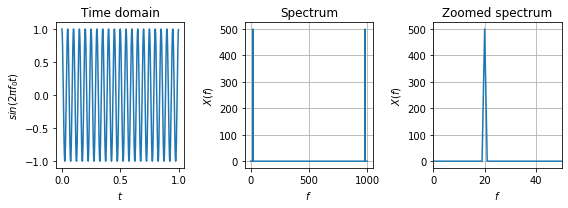

In [9]:
Fs = 1000
f0 = 20
t = np.arange(0, 1, 1/Fs)  # Calculate the time points where the sampling occurs
N = len(t)                 # number of samples in the sampled signal
cos_t = np.cos(2*np.pi*f0*t)

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(t, cos_t)
plt.xlabel('$t$')
plt.ylabel(r'$sin(2 \pi f_0 t)$')
plt.title('Time domain')

X_f = np.fft.fft(cos_t)
f = np.arange(0, Fs, Fs/N)
plt.subplot(132)
plt.plot(f, abs(X_f))
plt.ylabel('$X(f)$')
plt.xlabel('$f$')
plt.title('Spectrum')
plt.grid(True)

plt.subplot(133)
plt.plot(f, abs(X_f))
plt.xlabel('$f$')
plt.ylabel('$X(f)$')
plt.xlim((0, 50))
plt.title('Zoomed spectrum')
plt.grid(True)
plt.tight_layout()

As we know, the cosine wave consists only of a single frequency. However, when looking at the full spectrum (in the center figure) there are 2 peaks: One in the very beginning (actually, it's at $f=20$Hz) and the other at the very and of the x-axis (it's at $f=(1000-20)$Hz). Why's that? Remember the Nyquist sampling theorem, that we can actually only use the frequencies up to $f=F_s/2$, as the higher frequencies are just a mirror of the lower frequencies. 

From math we know
$$ \cos(2\pi f_0t) = \frac{1}{2}(\exp(j2\pi f_0t)+\exp(-j2\pi f_0t),$$
i.e. we can represent a cosine as a sum of two complex exponentials, one with positive frequency $f_0$ and one with negative frequency $-f_0$. How does this fit into our calculations, where are the negative frequencies? 

The $k$th bin of the DFT is calculated with the exponential term $\exp(-j2\pi\frac{nk}{N})$. Now, knowing about the periodicity of the exponential, the $k$th last DFT bin uses the exponential $\exp(-j2\pi n\frac{(N-k)}{N}=\exp(-j2\pi \frac{-kn}{N})$. This means, we can identify the $k$th last DFT bin with a negative frequency. As such, we identify the second half of the frequency axes as the negative frequencies, such that the overall frequencies range from $F=[-F_s/2, -F_s/2+F_s/N, -F_s/2+2F_s/N, \dots, 0, F_s/N, \dots, F_s/2-F_s/N]$. This more common understanding of the DFT frequency bins requires to rotate the DFT output as well. This is, where the function `fftshift` comes into play: It swaps the first and second half of its input sequence:

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


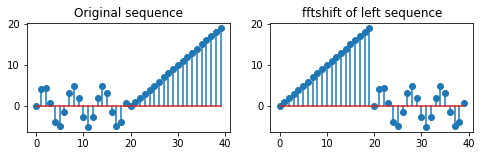

In [10]:
N2 = 20 # N/2
H1 = 5*np.sin(np.arange(N2))  # first half of the signal
H2 = np.arange(N2) # second half of the signal
H = np.hstack([H1, H2])
plt.figure(figsize=(8,2))
plt.subplot(121)
plt.stem(H)
plt.title('Original sequence')

plt.subplot(122)
plt.stem(np.fft.fftshift(H))
plt.title('fftshift of left sequence');

Now, let us replot the spectrum of our signal, but this time using `fftshift` and negative frequencies:

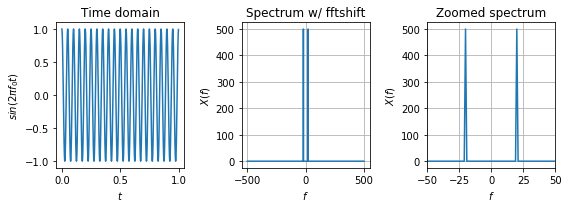

In [11]:
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(t, cos_t)
plt.xlabel('$t$')
plt.ylabel(r'$sin(2 \pi f_0 t)$')
plt.title('Time domain')

f2 = np.arange(-Fs/2, Fs/2, Fs/N)  # the frequency axis including negative frequencies
plt.subplot(132)
plt.plot(f2, np.fft.fftshift(abs(X_f)))
plt.ylabel('$X(f)$')
plt.xlabel('$f$')
plt.title('Spectrum w/ fftshift')
plt.grid(True)

plt.subplot(133)
plt.plot(f2, np.fft.fftshift(abs(X_f)))
plt.xlabel('$f$')
plt.ylabel('$X(f)$')
plt.xlim((-50, 50))
plt.title('Zoomed spectrum')
plt.grid(True)
plt.tight_layout()

Now, we see the common representation of the cosine as the sum of two diracs, that occur at positive and negative frequencies. 

To summarize:

> - The DFT output frequency bins correspond to the frequencies $F_k=k\frac{F_s}{N}$.
> - With the more common frequency axis of half positive, half negative frequencies, the frequency bins for a DFT are given by `f=np.arange(-Fs/2, Fs/2, Fs/N)`. In this case, an `fftshift` of the DFT output is required before plotting the result. (*This expression is only exact when N is even. If N is odd, [slightly more complex operation](http://dsp.stackexchange.com/questions/2970/how-to-make-frequency-axis-for-even-and-odd-fft-length) would need to be calculated*)

Finally, let us define a convenience function that calculates the `fftshift` of the `fft` of a sequence.

In [12]:
def dft(xn, fftLen=None):
    if fftLen is None:
        fftLen = len(xn)
    return np.fft.fftshift(np.fft.fft(xn, fftLen))

## Spectral Leakage

Let us calculate the DFT of the signal
$$x(t) = \cos(2\pi f_0 t)$$
with $f_0=2Hz$ which we sample with sampling frequency $F_s=50Hz$ over a time of T=1.6s:

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


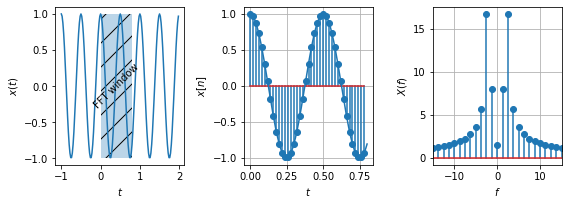

In [13]:
Fs = 50 # sampling frequency
f0 = 2# signal frequency
T = 0.8 # time duration 
t = np.arange(0, T, 1/Fs)  # the time samples
t_fine = np.arange(0, T, 1/(100*Fs))
t_long = np.arange(-1, 2, 1/Fs) 
N = len(t)
f = np.arange(-Fs/2, Fs/2, Fs/N)  # the frequency bin axis

cos_t = np.cos(2*np.pi*f0*t)  # generate the sampled signal
cos_tfine = np.cos(2*np.pi*f0*t_fine)

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(t_long, np.cos(2*np.pi*f0*t_long))
plt.gca().add_patch(patches.Rectangle((0, -1), T, 2, hatch='/', alpha=0.3))
plt.text(T/2, 0, "FFT window", ha='center', va='center', rotation=45)
plt.xlabel('$t$'); plt.ylabel('$x(t)$')

plt.subplot(132)
plt.stem(t, cos_t)
plt.plot(t_fine, cos_tfine)
plt.xlabel('$t$'); plt.ylabel('$x[n]$');  plt.grid(True)

plt.subplot(133)
plt.stem(f, abs(dft(cos_t)))
plt.xlabel('$f$'); plt.ylabel('$X(f)$'); plt.grid(True)
plt.xlim((-15, 15));
plt.tight_layout();

The first figure shows the periodic signal and the time for the DFT window. The second figure shows the sampled part of the signal and rightmost is the DFT output. Our signal only has one frequency component: $x(t)=\cos(2\pi f_0t)$, so we would expect only a single frequency bin to be non-zero. But, what's that? Certainly, the frequency bin around $f_0$ is the strongest, but there are non-zero values around this maximum. What is happening? First, let's look at the frequencies the frequency bins correspond to:



In [14]:
print (np.round(f[N//2:N//2+10], 3))

[ 0.    1.25  2.5   3.75  5.    6.25  7.5   8.75 10.   11.25]


As we see, there is no explicit frequency bin that represents the frequency $f_0=2Hz$. So, the DFT *spreads* the measured energy for $f_0=2Hz$ onto the neighboring frequency bins. The nearest frequency bin ($f=2.5$) gets the highest value, $f=1.25$ the second highest, $f=3.75$ the theird and so on. This explains qualitatively what we see. 

But, let's try to analyze this in more detail. Let us recap the main property of the DFT:
> The Discrete Fourier Transform (DFT) assumes that its input signal is one period of a periodic signal. Its outputs are the discrete frequencies of this periodic signal.

This means, what the DFT actually assumes is that the signal looks like this:

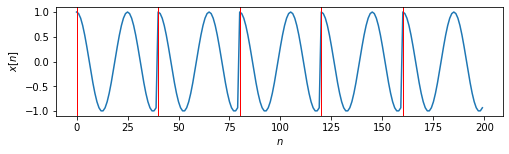

In [15]:
dft_assumed = np.hstack([cos_t]*5)
plt.figure(figsize=(8,2))
plt.plot(dft_assumed);
for n in range(5):
    plt.axvline(n*N, lw=1, color='red')
plt.xlabel('$n$'); plt.ylabel('$x[n]$');

We see a periodic signal, but it is not a pure cosine function. There is an abrupt jump at the signal transition between one period and the next one (the period boundary is indicated by the red lines), because we did not measure a full period of the original signal. Now, looking at this signal is it pretty clear that it does not consist of a single cosine wave, but there need to be other frequencies contained, that produce the strange behaviour at the period's boundary. This is exactly what we see in the DFT output. This phenomenon is called **spectral leakage** because even though the signal $x(t)$ is a periodic signal of frequency $f_0$, if we take a part of the signal and calculate the DFT spectrum from it, we see multiple frequencies occuring, due to the strange behaviour at the period's boundary. In case we measure exactly an integer multiple of the signal period, the spectral leakage will disappear, because the DFT sees a purely periodic signal in this case:

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


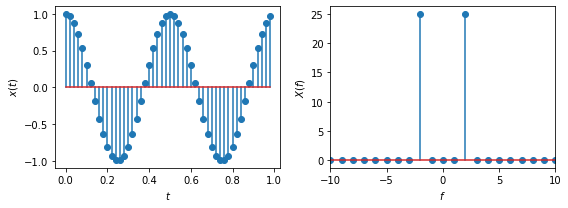

In [16]:
T = 1; N = Fs*T
t = np.arange(0,T,1/Fs)
cos_t = np.cos(2*np.pi*f0*t)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.stem(t, cos_t);
plt.xlabel('$t$'); plt.ylabel('$x(t)$');

f = np.arange(-Fs/2, Fs/2, Fs/N)
plt.subplot(122)
plt.stem(f, abs(dft(cos_t)))
plt.xlabel('$f$'); plt.ylabel('$X(f)$');
plt.xlim((-10, 10));
plt.tight_layout();

As we can see, for this configuration, there is no spectral leakage occuring, because we have measured exactly 2 periods of the original signal.

## Zero-Padding the DFT

The previous section has shown that, if we window a signal with a length that is not an integer multiple of its period, we will suffer from spectral leakage and the true frequency of the underlying tone will be invisible. Can we still find the true frequency of the tone?

Let us remember the section about the continuous Fourier Transform. The CTFT of a period signal is a discrete spectrum. But, if we multiply the periodic signal with a rectangular window, the spectrum becomes continuous, as it is the convolution of the discrete spectrum with a sinc-function (originating from the multiplication with the rectangular window in the time domain). Let's do this again with our previous example, but using the CTFT this time:

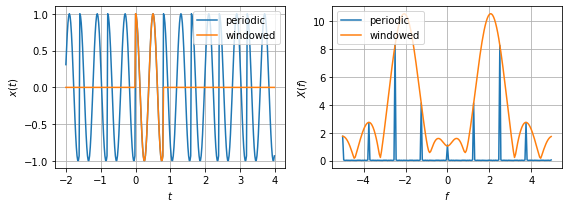

In [17]:
T = 0.8
Fs = 50
f0 = 2
cos_fn = lambda t: np.cos(2*np.pi*f0*t)
periodic_cos_fn = lambda t: cos_fn(np.mod(t, T))
windowed_cos_fn = lambda t: cos_fn(t) * ((abs(t-T/2) <= T/2).astype(float))

t = np.arange(-2, 4, 1/Fs)
f = np.arange(-5, 5, 1/20)

X_periodic = cft(periodic_cos_fn, f)
X_windowed = cft(windowed_cos_fn, f)*20/0.8

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, periodic_cos_fn(t), label='periodic')
plt.plot(t, windowed_cos_fn(t), label='windowed')
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True)
plt.legend(fontsize=10)

plt.subplot(122)
plt.plot(f, abs(X_periodic), label='periodic')
plt.plot(f, abs(X_windowed), label='windowed')
plt.xlabel('$f$'); plt.ylabel('$X(f)$'); plt.grid(True); plt.tight_layout();
plt.legend(fontsize=10, loc='upper left');

The green spectrum, corresponding to the windowed function shows its maximum at the correct frequency $f_0=2Hz$. This means, even though the DFT could not tell us exactly what the frequency of the windowed signal was, the CTFT can tell us. Can we also use the DFT to find out this information? Yes! The answer is **zero padding** the signal. The idea is to approximate the CTFT of the windowed signal by letting the input signal to the DFT also look like an aperiodic windowed version. However, we know that the DFT always assumes the signal is periodic, but we can still get a similar effect: Let us take our measured window and append zeros to it:

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()
C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


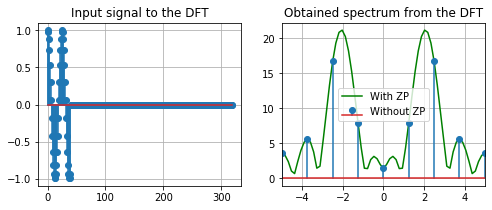

In [18]:
T=0.8; Fs = 50; f0 = 2;
t = np.arange(0, T, 1/Fs)
N = len(t)
cos_t = np.cos(2*np.pi*f0*t) # the measured signal
N = len(t) # number of samples
N_zp = 7*N # The number of zeros to add
zero_padded_cos_t = np.hstack([cos_t, np.zeros(N_zp)])

f = np.arange(-Fs/2, Fs/2, Fs/N)

N_fft = len(zero_padded_cos_t)
f_zp = np.arange(-Fs/2, Fs/2, Fs/N_fft)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.stem(zero_padded_cos_t);
plt.title('Input signal to the DFT')
plt.grid(True)

plt.subplot(122)
plt.plot(f_zp, abs(dft(zero_padded_cos_t)), 'g-', label='With ZP')
plt.stem(f, abs(dft(cos_t)), label='Without ZP')
plt.xlim((-5,5))
plt.grid(True);
plt.legend(fontsize=10)
plt.title('Obtained spectrum from the DFT');

Here, we have performed zero-padding by adding $7N$ zeros to the windowed signal. Accordingly, the distance between two adjacent frequency bins becomes $F_s/(8N)$ since the DFT input signal now has length of $8N$ samples. 

Looking at the figure, also the DFT can tell us, what was the frequency of the original signal: $f_0=2Hz$, since the maximum of the blue curve occurs at 2Hz. For comparison, look at the frequency points that were calculated by the non-zeropadded DFT: we have a much coarser spacing between the DFT frequency bins, making it hard to tell the exact frequency. However, the ZP curve in green is only an interpolated version of the blue dots. As such, zero-padding a signal does not increase the amount of information that is contained in the signal. But, it can help in identifying dominant frequencies more accurately.

## Frequency Resolution
Let us now consider a signal that conists of two tones of different frequencies $f_0, f_1$ which are close to each other:$$x(t)=\cos(2\pi f_0t) + \cos(2\pi f_1 t).$$

The task is now to provide information on the frequency of both tones. Let us first generate such a signal and see hot it looks like:

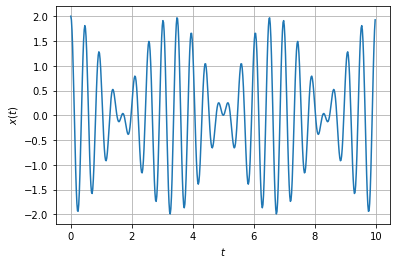

In [19]:
Fs = 50
f0 = 2
f1 = 2.3
T = 10
t = np.arange(0, T, 1/Fs)
x = lambda t: np.cos(2*np.pi*f0*t) + np.cos(2*np.pi*f1*t)

plt.plot(t, x(t));
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid();

We see, the signal is still periodic, but we cannot clearly see which frequencies are contained. Let's see, if the DFT operations can reveal the contents. First, we start with an FFT window length of $T=1s$:

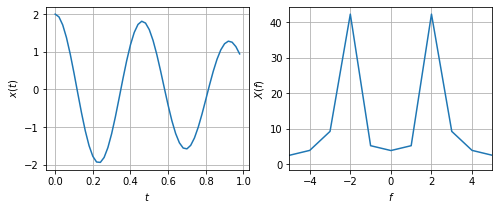

In [20]:
T = 1; N = Fs*T
t = np.arange(0, T, 1/Fs)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, x(t));
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True)

f = np.arange(-Fs/2, Fs/2, Fs/N)
plt.subplot(122)
plt.plot(f, abs(dft(x(t))))
plt.xlim((-5,5));
plt.xlabel('$f$'); plt.ylabel('$X(f)$'); plt.grid(True);

As we see, the DFT can only identify one significant frequency from the signal, which is estimated at the frequency $f=2Hz$. It cannot tell us that there are two different frequencies contained. Let's try, if we can use zero-padding to find the two frequencies (Here, we use the 2nd parameter for the FFT function to directly determine the FFT length to be $32N$, without explicitely adding zeros to our signal):

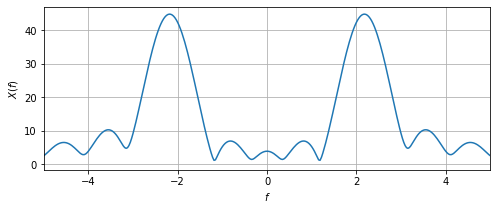

In [21]:
f_zp = np.arange(-Fs/2, Fs/2, Fs/(32*N))
plt.figure(figsize=(8,3))
plt.plot(f_zp, abs(dft(x(t), 32*N)))
plt.xlim((-5,5));
plt.xlabel('$f$'); plt.ylabel('$X(f)$'); plt.grid(True)

Apparently, also with Zero-padding, we cannot distinguish the two frequencies. The estimate would be that the signal consists of a tone with $f=2.2Hz$. This is in line with the statement, that ZP does not reveal extra information from the spectrum. Instead it merely interpolates the coarse spectrum to become more smooth. It does not help in distinguishing between two close frequencies. 

So, how can we improve the resolution of our DFT? We know, the DFT bins are determined by the length of the recorded signal: The longer the signal, the finer the useful DFT bins (in contrast to the interpolated bins from zero-padding). So, the solution is to record a longer portion of the signal, such that both frequencies will occur on separate bins. Let's measure the signal with a duration of 10s:

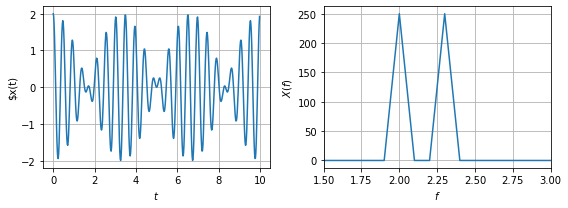

In [22]:
T = 10
t = np.arange(0, T, 1/Fs)
N = len(t)
f = np.arange(-Fs/2, Fs/2, Fs/N)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(t, x(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)'); plt.grid(True)

plt.subplot(122)
plt.plot(f, abs(dft(x(t))))
plt.xlabel('$f$'); plt.ylabel('$X(f)$'); plt.grid(True)
plt.xlim((1.5,3));
plt.tight_layout();

(*Note that the spectrum is zoomed strongly zoomed too see the two different peaks*). With this amount of real measurement, we can easiliy distinguish between the two tones in the signal: There is one tone at $f=2Hz$ and one at $f=2.3Hz$. 

## Conclusion
We can now conclude the following

> - The DFT is vulnerable to **spectral leakage**. Spectral leakage occurs when a non-integer number of periods of a signal is sent to the DFT. Spectral leakage lets a single-tone signal be spread among several frequencies after the DFT operation. This makes it hard to find the actual frequency of the signal.
> - For a single-tone signal, we can find its actual frequency even when spectral leakage occurs. We can **zero-pad** the signal and perform a larger DFT to get a more frequency bins.
> - Zero-padding a signal does not reveal more information about the spectrum, but it only interpolates between the frequency bins that would occur when no zero-padding is applied. In particular, **zero-padding does not increase the spectral resolution**.
> - To **increase the spectral resolution, longer durations of real measurements are necessary**. A longer measurement obtains more information from the measured signal, since the resulting frequency bins are distributed finer.

# Application: Dual-Tone multi-frequency signaling

Let us now apply the gained knowledge to an intuitive problem: [phone dialing](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling "Wikipedia Page"). When your phone dials a number, you can hear a sequence of sounds. There, each sound encodes a different digit to be dialed. The sounds are two-tone signals according to $$x(t)=\cos(2\pi f_1 t) + \cos(2\pi f_2 t),$$
where $f_1$ and $f_2$ depend on the digit to be dialed. The frequencies are encoded according to the following table:

|       | 1209Hz | 1336Hz | 1477Hz | 1633Hz |
|-------|--------|--------|--------|-------:|
| 697Hz |    1   |    2   |    3   |   A    |
| 770Hz |    4   |    5   |    6   |   B    |
| 852Hz |    7   |    8   |    9   |   C    |
| 941Hz |    *   |    0   |    #   |   D    |

So, for example, when dialing the digit 5, the corresponding signal has the form
$$x_5(t)=\cos(2\pi f_1 t) + \cos(2\pi f_2 t), \quad\text{with } f_1=770Hz \quad f_2=1336Hz.$$

Let us replicate this table in code:

In [23]:
F1 = np.array([697, 770, 852, 941])
F2 = np.array([1209, 1336, 1477, 1633])
tones = {'1': (0,0),
        '2': (0,1),
        '3': (0,2),
        '4': (1,0),
        '5': (1,1),
        '6': (1,2),
        '7': (2,0),
        '8': (2,1),
        '9': (2,2),
        '0': (3,1),
        '*': (3,0),
        '#': (3,2),
        'A': (0,3),
        'B': (1,3),
        'C': (2,3),
        'D': (3,3)}
for number, inds in sorted(tones.items()):
    print ("%s: %dHz %dHz (delta-F: %dHz)" % (number, F1[inds[0]], F2[inds[1]], (F2[inds[1]]-F1[inds[0]])))

#: 941Hz 1477Hz (delta-F: 536Hz)
*: 941Hz 1209Hz (delta-F: 268Hz)
0: 941Hz 1336Hz (delta-F: 395Hz)
1: 697Hz 1209Hz (delta-F: 512Hz)
2: 697Hz 1336Hz (delta-F: 639Hz)
3: 697Hz 1477Hz (delta-F: 780Hz)
4: 770Hz 1209Hz (delta-F: 439Hz)
5: 770Hz 1336Hz (delta-F: 566Hz)
6: 770Hz 1477Hz (delta-F: 707Hz)
7: 852Hz 1209Hz (delta-F: 357Hz)
8: 852Hz 1336Hz (delta-F: 484Hz)
9: 852Hz 1477Hz (delta-F: 625Hz)
A: 697Hz 1633Hz (delta-F: 936Hz)
B: 770Hz 1633Hz (delta-F: 863Hz)
C: 852Hz 1633Hz (delta-F: 781Hz)
D: 941Hz 1633Hz (delta-F: 692Hz)


Now, let's write function that generates the signal for a given digit with a certain duration:

In [24]:
Fs = 8000  # sampling frequency of our discrete system
def tone(number, duration):
    """generate the sound for number with given duration"""
    inds = tones[number]
    f1 = F1[inds[0]]
    f2 = F2[inds[1]] # get both frequencies for the digit
    
    t = np.arange(0, duration, 1/Fs)
    return np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)  # calculate signal

# Generate tone for digit 2 with duration of 1s
Audio(data=tone(number='2', duration=1), rate=Fs)

Now, let's write a function that concatenates the sounds for several digits to emulate the dialing of a full phone number:

In [25]:
def dialNumber(numbers, toneDuration):
    data = [tone(n, toneDuration) for n in numbers]
    return np.hstack(data)
Audio(data=dialNumber("0049176854864321", toneDuration=0.1), rate=Fs)

The task now is to write a program that can extract the dialed number from this sound sequence. 

How should we proceed? Lets follow this rough idea:

1. Assuming we know the duration of each tone, split the sound into the tone for each digit.
2. Perform DFT of the separate tones.
3. Check for two distinct peaks in the spectrum to find, which frequencies were contained in the signal.
4. Map the frequencies to the dialed numbers

The crucial step is step 3., where we need to distinguish between two frequency components that might be close to each other. First, let's run a naive DFT on the sound for some digit. We choose the digit `*`, because it has the least distance between the two contained frequencies, which makes it the most challenging digit.

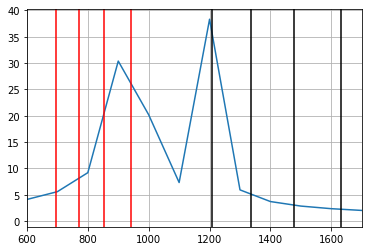

In [26]:
def markPossibleTones():
    for f in F1:
        plt.axvline(f, color='r')
    for f in F2:
        plt.axvline(f, color='k')

data = tone(number='*', duration=1e-2)
f = np.arange(-Fs/2, Fs/2, Fs/len(data))
plt.plot(f, abs(dft(data)))
markPossibleTones()
plt.xlim((600, 1700))
plt.grid(True)

For a recorded signal of length of $0.01s$, we can already clearly see that there are two different frequency components, but, in particular for the lower frequency, the exact value of this frequency is not known. Let's remember that we can use zero-padding to get a more accurate estimate of the frequency of a given tone in a signal. We can resort to zero-padding to find the frequency, because we can already clearly distinguish two separate peaks in the spectrum, which correspond to the two contained frequencies:

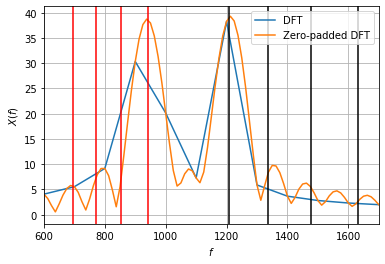

In [27]:
f_ZP = np.arange(-Fs/2, Fs/2, Fs/(8*len(data)))
plt.plot(f, abs(dft(data)), label='DFT')
plt.plot(f_ZP, abs(dft(data, 8*len(data))), label='Zero-padded DFT')
markPossibleTones()
plt.xlim((600, 1700))
plt.grid(True)
plt.legend(fontsize=10);
plt.xlabel('$f$'); plt.ylabel('$X(f)$');

Now, we clearly see, which tones are contained in the signal: It's the highest of the lower and lowest of the higher frequencies, corresponding to digit `*`. Hence, we should resort to zero-padding our signal before the DFT to get more accurate information about the actually contained tones.

Now, let's write a function to perform the estimation of a tone given its spectrum:

In [28]:
def estimateDigit(sound):
    N = len(sound)
    f_ZP = np.arange(-Fs/2, Fs/2, Fs/(8*N)) # 8 times zeropadding
    X = abs(dft(sound, 8*N))
    
    # Technique: We check each of the possible frequencies 
    # and choose the frequency which has the highest amplitude in the spectrum
    
    # Find the index in the frequency axis, which are closest to the allowed frequencies
    f_ind_lower = np.array([np.argmin(abs(f_ZP - f)) for f in F1])
    f_ind_higher = np.array([np.argmin(abs(f_ZP - f)) for f in F2])
    
    # extract the spectrum amplitudes for the frequencies of interest
    amplitude_lower = X[f_ind_lower] 
    amplitude_higher = X[f_ind_higher]
    
    # choose the largest one as the estimated frequency component
    f1_ind = np.argmax(amplitude_lower)
    f2_ind = np.argmax(amplitude_higher)
    
    return [x[0] for x in tones.items() if x[1] == (f1_ind, f2_ind)][0]

digit = '7'
print ("Estimated tone for digit '%s': '%s'" % (digit, estimateDigit(tone(digit, 1/100))))

Estimated tone for digit '7': '7'


Clearly, the provided function can estimate the dialed digit based on the frequency contained in the two tones. Now, let's extend this to estimate the dialed sequence from a sequence of tones:

In [29]:
def estimateNumber(data, toneDuration):
    N_perTone = int(Fs*toneDuration)
    tones = data.reshape((-1, N_perTone))
    estimated = [estimateDigit(tones[i,:]) for i in range(tones.shape[0])]
    return "".join(estimated)
toneDuration = 1/100
number = "0123456789ABCD#*"
data = dialNumber(number, toneDuration)
estimated = estimateNumber(data, toneDuration)
print ("Dialed number: %s - Received Number: %s Correct: %s" % (number, estimated, number==estimated))
Audio(data, rate=Fs)

Dialed number: 0123456789ABCD#* - Received Number: 0123456789ABCD#* Correct: True


While listening to the audio, one can hardly hear anything at all. However, the function works nicely and returns the dialed number based on the contained frequencies. Now, let's try, if it can also estimate the number, when the duration for the tones gets even shorter:

In [30]:
toneDuration = 1/400
data = dialNumber(number, toneDuration)
estimated = estimateNumber(data, toneDuration)
print ("Dialed number: %s - Received Number: %s Correct: %s" % (number, estimated, number==estimated))
Audio(data, rate=Fs)

Dialed number: 0123456789ABCD#* - Received Number: 8123556589ABCD#* Correct: False


Finally, despite zero-padding our signal, the function cannot distinguish between the different frequencies and the estimated number is wrong. This is due to the fact that the FFT window was too short to allow enough spectral resolution.

As a final test for the function, let us add some noise to the signal:

Dialed number: 7 - Received Number: 7 Correct: True


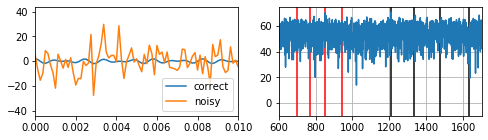

In [31]:
def evaluateDigitWithNoise(digit, sigma2, toneDuration):
    data = tone(digit, toneDuration)
    t = np.arange(0, toneDuration, 1/Fs)
    data_with_noise = data + sigma2*np.random.randn(len(data))
    estimated = estimateDigit(data_with_noise)
    print ("Dialed number: %s - Received Number: %s Correct: %s" % (digit, estimated, digit==estimated))
    plt.figure(figsize=(8,2))
    plt.subplot(121)
    plt.plot(t, data, label='correct')
    plt.plot(t, data_with_noise, label='noisy')
    plt.legend(fontsize=10)
    plt.xlim((0, 0.01))

    plt.subplot(122)
    markPossibleTones()
    f_ZP = np.arange(-Fs/2, Fs/2, Fs/(8*len(data_with_noise)))
    X_ZP = abs(dft(data_with_noise, 8*len(data_with_noise)))
    plt.plot(f_ZP, 20*np.log10(X_ZP))
    plt.xlim((600, 1700))
    plt.grid(True)

    return data_with_noise

Audio(evaluateDigitWithNoise(digit, 10, 1), rate=Fs)

Even though we have put a significant noise into the signal (a human has severe problems hearing a single tone at all and the time-domain signal just looks like noise), the algorithm is still able to detect the correct data point. Looking at the spectrum, we still see two distinct peaks in the spectrum. Let us now additionally reduce the symbol duration:

Dialed number: 7 - Received Number: 7 Correct: True


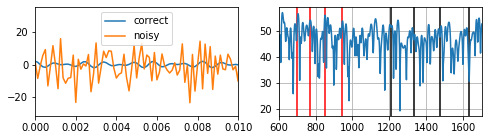

In [32]:
Audio(evaluateDigitWithNoise(digit, 10, .1), rate=Fs)

Now, finally, the algorithm is not able to detect the digit anymore: The noise is too strong for the short amount of time, where the signal was recorded. 